# Chapter 3

In the chapter 3 of "Web Scraping with Python" you were able to learn more about the following subjects:
* Tracking internal links of website
  * According to pattern
  * All internal links
* Website mapping
* Collecting data
* Tracking through internet

The following cells aim to practice the contents listed above. For any sugestions, contact *gabriel.vasconcelos@usp.br*

Use the website https://scraping-cap3.netlify.app/ to answer this notebook.

In [1]:
# Import BeautifulSoup and other libraries you find useful
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.error import HTTPError, URLError
import re
import networkx as nx
import matplotlib.pyplot as plt
import random

In [2]:
# Get the website https://scraping-cap3.netlify.app/ and pass it to a BeautifulSoup object 
# with proper error handling
def getBSObject(site):
    try:
        html = urlopen(site)
    except HTTPError as e:
        return None
    except URLError as e:
        return None
    bs = BeautifulSoup(html, 'html.parser')
    return bs
    
bs = getBSObject('https://scraping-cap3.netlify.app/index.html')

### a.
Get all internal links from the domain.

In [3]:
# Code below
# Tip: use BFS algorithm to do a full mapping of the domain

def getInternalLinksOfPage(bsObject):
    links = bsObject.find_all('a', {'href': re.compile('(^\.*\/.+$)|(https:\/\/scraping-cap3\.netlify\.app\/.*)')})
    links = set([link.attrs['href'] for link in links])
    return links


links = getInternalLinksOfPage(bs)
links

{'/baixistas',
 '/bandas',
 '/bateristas',
 '/guitarristas',
 '/tecladistas',
 '/vocalistas'}

In [4]:
def makeInternalLinkAnURL(link):
    url = 'https://scraping-cap3.netlify.app/'
    if link.startswith('./'):
        url += link[2:]
    elif link.startswith('/'):
        url += link[1:]
    elif link.startswith('../'):
        url += link[3:]
    else:
        return link
    
    return url
    

def bfs():
    links = set()
    addedToQueue = {'https://scraping-cap3.netlify.app/index.html'}
    queue = ['https://scraping-cap3.netlify.app/index.html']
    while len(queue) > 0:
        curPage = makeInternalLinkAnURL(queue.pop(0))
        links.add(curPage)
        bs = getBSObject(curPage)
        nextPages = getInternalLinksOfPage(bs)
        for page in nextPages:
            formatedPage = makeInternalLinkAnURL(page)
            if formatedPage not in addedToQueue:
                queue.append(formatedPage)
                addedToQueue.add(formatedPage)
                
    return links

In [5]:
linksOfDomain = bfs()
linksOfDomain

{'https://scraping-cap3.netlify.app/baixistas',
 'https://scraping-cap3.netlify.app/baixistas/dee_dee_ramone',
 'https://scraping-cap3.netlify.app/baixistas/geezer_butler',
 'https://scraping-cap3.netlify.app/baixistas/john_paul_jones',
 'https://scraping-cap3.netlify.app/baixistas/krist_novoselic',
 'https://scraping-cap3.netlify.app/baixistas/paul_mccartney',
 'https://scraping-cap3.netlify.app/baixistas/roger_glover',
 'https://scraping-cap3.netlify.app/baixistas/simon_gallup',
 'https://scraping-cap3.netlify.app/bandas',
 'https://scraping-cap3.netlify.app/bandas/black_sabbath',
 'https://scraping-cap3.netlify.app/bandas/deep_purple',
 'https://scraping-cap3.netlify.app/bandas/led_zeppelin',
 'https://scraping-cap3.netlify.app/bandas/nirvana',
 'https://scraping-cap3.netlify.app/bandas/ramones',
 'https://scraping-cap3.netlify.app/bandas/the_beatles',
 'https://scraping-cap3.netlify.app/bandas/the_cure',
 'https://scraping-cap3.netlify.app/bandas/the_doors',
 'https://scraping-cap3

### b.
Get all external links from the domain.

In [6]:
# Code below

def getExternalLinksOfPage(bsObject):
    aTags = bsObject.find_all('a')
    links = set([tag.attrs['href'] for tag in aTags if 'href' in tag.attrs])
    links.difference_update(getInternalLinksOfPage(bsObject))
    return links

bs = getBSObject('https://scraping-cap3.netlify.app/index.html')
getExternalLinksOfPage(bs)

{'/',
 'https://github.com/kibonusp',
 'https://www.linkedin.com/in/gabrielfreitas-xv/'}

In [7]:
externalLinksOfDomain = set()
for link in linksOfDomain:
    bs = getBSObject(link)
    externalLinksOfDomain.update(getExternalLinksOfPage(bs))
    
externalLinksOfDomain

{'/',
 'https://github.com/kibonusp',
 'https://www.linkedin.com/in/gabrielfreitas-xv/'}

### c.
Get the title of each page in the website, its url and the first paragraph.

In [8]:
# Code below
def getInfo(url):
    bs = getBSObject(url)
    firstParagraph = None
    if bs.p:
        firstParagraph = bs.p.get_text()
    title = None
    if bs.title:
        title = bs.title.get_text()
    return {'url': url, 'title': title, 'firstParagraph': firstParagraph}

data = []
for page in linksOfDomain:
    data.append(getInfo(page))
data

[{'url': 'https://scraping-cap3.netlify.app/baixistas',
  'title': 'Baixistas',
  'firstParagraph': None},
 {'url': 'https://scraping-cap3.netlify.app/bandas/deep_purple',
  'title': 'Deep Purple',
  'firstParagraph': 'Deep Purple é uma banda britânica de rock formada em Londres, em 1968.[1] Juntamente com as bandas Black Sabbath e Led Zeppelin, o Deep Purple é considerado um dos pioneiros do heavy metal e do hard rock moderno, embora alguns de seus integrantes tenham tentado não se categorizar como apenas um destes gêneros.[2][3] A banda também incorporou elementos do barroco, da psicodelia, do blues e do rock progressivo ao seu som.[4] Foram listados pelo Livro Guiness dos Recordes "como a banda com o som mais alto ao vivo no mundo", e venderam mais de 150 milhões de álbuns ao redor do mundo.[5][6]'},
 {'url': 'https://scraping-cap3.netlify.app/vocalistas',
  'title': 'Vocalistas',
  'firstParagraph': None},
 {'url': 'https://scraping-cap3.netlify.app/baixistas/geezer_butler',
  'tit

### d.
Create an adjacency list of the domain (directed graph).

In [9]:
# Code below
adjacencyList = {}
for page in linksOfDomain:
    adjacencyList[page] = [makeInternalLinkAnURL(link) for link in getInternalLinksOfPage(getBSObject(page))]
    
adjacencyList

{'https://scraping-cap3.netlify.app/baixistas': ['https://scraping-cap3.netlify.app/bandas',
  'https://scraping-cap3.netlify.app/baixistas/krist_novoselic',
  'https://scraping-cap3.netlify.app/baixistas/roger_glover',
  'https://scraping-cap3.netlify.app/baixistas/simon_gallup',
  'https://scraping-cap3.netlify.app/baixistas/paul_mccartney',
  'https://scraping-cap3.netlify.app/baixistas/john_paul_jones',
  'https://scraping-cap3.netlify.app/baixistas',
  'https://scraping-cap3.netlify.app/baixistas/dee_dee_ramone',
  'https://scraping-cap3.netlify.app/tecladistas',
  'https://scraping-cap3.netlify.app/vocalistas',
  'https://scraping-cap3.netlify.app/bateristas',
  'https://scraping-cap3.netlify.app/baixistas/geezer_butler',
  'https://scraping-cap3.netlify.app/guitarristas'],
 'https://scraping-cap3.netlify.app/bandas/deep_purple': ['https://scraping-cap3.netlify.app/bandas',
  'https://scraping-cap3.netlify.app/baixistas/roger_glover',
  'https://scraping-cap3.netlify.app/baterist

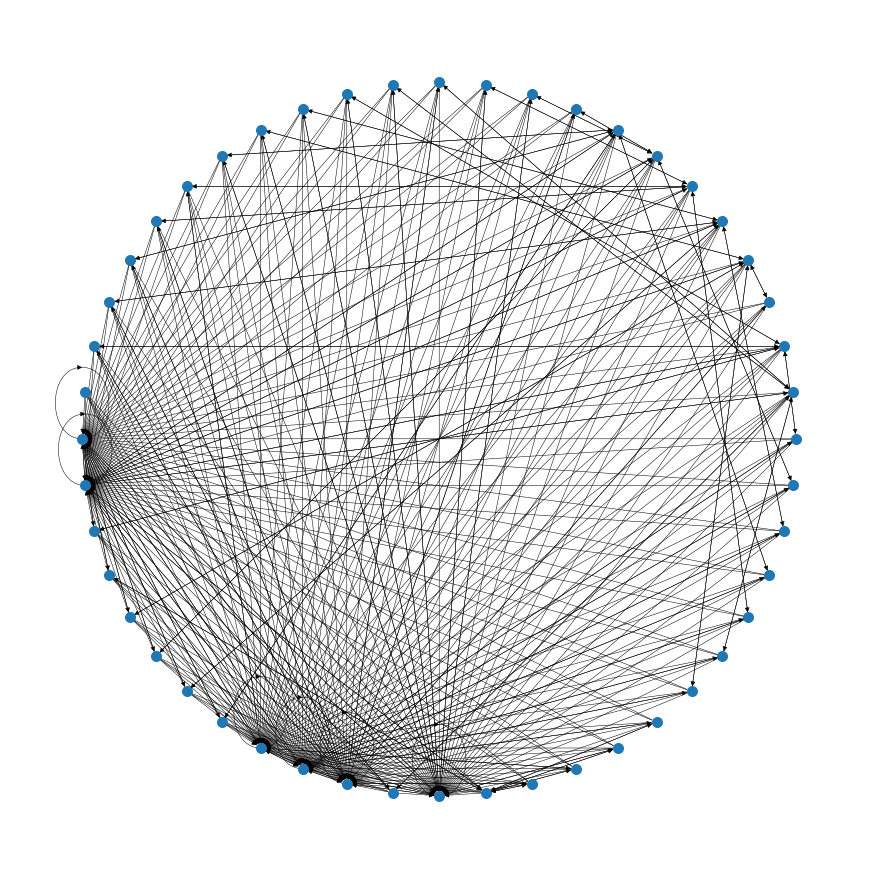

In [19]:
# Use networkx to generate a visualization of the graph

G = nx.DiGraph()

for fromSite in adjacencyList:
    for toSite in adjacencyList[fromSite]:
        G.add_edge(fromSite, toSite)
        
plt.figure(3,figsize=(12,12)) 
nx.draw(G, pos=nx.shell_layout(G), node_size=100, width=0.5)
plt.show()

### e.
From the website external links, choose one randomly and create a internet crawler.

In [11]:
# Code below
def crawler(site):
    print(site)
    found = True
    while found:
        bs = getBSObject(site)
        site = findExternalLink(bs)
        if not site:
            found = False
        print(site)
        
            
def findExternalLink(site):
    if not site:
        return None
    externalLinks = getExternalLinksOfPage(site)
    nextLink = random.choice(list(externalLinks))
    print(nextLink)
    if not nextLink:
        internalLinks = getInternalLinksOfPage(site)
        i = 0
        while not nextLink and i < len(internalLinks):
            nextLink = findExternalLink(site + internalLinks[i])
            i += 1
        return nextLink
    return nextLink

In [12]:
crawler('https://scraping-cap3.netlify.app/index.html')

https://scraping-cap3.netlify.app/index.html
https://github.com/kibonusp
https://github.com/kibonusp
https://github.com/
https://github.com/
https://www.tiktok.com/@github
https://www.tiktok.com/@github
https://developers.tiktok.com/?refer=tiktok_web
https://developers.tiktok.com/?refer=tiktok_web
https://www.tiktok.com/business/&attr_source=tt_official_site&attr_medium=tt_official_site_guidance?enter_method=bottom_navigation
https://www.tiktok.com/business/&attr_source=tt_official_site&attr_medium=tt_official_site_guidance?enter_method=bottom_navigation
https://www.tiktok.com/business/solutions/creative
https://www.tiktok.com/business/solutions/creative
https://my.academywithtiktok.com/learn
https://my.academywithtiktok.com/learn


IndexError: list index out of range